### **Notes**
1. This notebook was entirely built and tested using Google Colab

2. Data : \

    a. Part 1 (Face Mask Detection) - The dataset has been downloaded to my Google Drive account in the directory *C:\Users\madhu\Google Drive\Colab Notebooks\Assignments\CVAdvanced* under the name *Part 1- Train data - images.npy*. The drive is mounted for accessing the directories. 

    b. Part 2 (Face Image Annotation) - The data set used is Part 2 - training images.zip. The annotations have been performed on the images in this data set. The result is downloaded as an Excel spreadsheet when the notebook completes execution
 
    c. Part 3 (Face Recognition) - The dataset has been downloaded to Google drive directory with the name as *Part 3 - Aligned Face Dataset from Pinterest.zip*. The pre-trained model weights are also stored here and used for building the network. 

    d. Part 4 (Traffic Density Estimation) - The two sample videos are taken as the input data set. An automation is performed to mark bounding boxes on traffic objects. The output videos that contain bounding boxes are downloaded at the end of the notebook execution

3. Running this notebook requires manual intervention at one point \
    a. Mounting the Google drive where training data sets, test samples, pre-trained models and other resources are stored  

4.The end to end execution time is about 80 minutes, which includes the time to download the required output videos and files

Import all required libraries used across this assignment

We also install pixellib library, that is used for Part 4 of the assignment

In [1]:
# Ignore warning messages
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True

# Essential python libraries for data processing 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
from sklearn.model_selection import train_test_split

# Google drive access libraries
from google.colab import drive, files
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm

# OpenCV for Image processing, OS for directory handling
import cv2,os, random, sys, csv
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from PIL import Image
import argparse

# Libararies for supervised machine learning
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Keras libraries for image data preprocessing, model building and training  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SpatialDropout2D, Conv2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Lambda, UpSampling2D, Reshape, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

#Object detection library
! pip install pixellib
import pixellib
from pixellib.instance import instance_segmentation

# Image display utility
from IPython.display import HTML, display

     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for imantics: filename=imantics-0.1.12-cp37-none-any.whl size=16033 sha256=b4d53ef66d5dc5e5e3695e166dc0816e771bd04c2c1017eac528871bd04f1a95
  Stored in directory: /root/.cache/pip/wheels/73/93/1c/9e2fc52eb74441941bc76cac441ddcc2c7ad67b18e1849e62a
Successfully built imantics


Firstly, we mount the Google drive containing data sets, models and videos. This is required for all parts of the assignment

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Part 1 - Face Mask Detection

In this part of the assignment, we are given a data set that contain one or more human faces per image. The data set is a subset of images found in http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

We will use a pre-trained Object Detection model (MobileNet - https://arxiv.org/pdf/1704.04861.pdf) that detects objects. Specifically, in this assignment, we use it to detect human faces in a given test image.

Load the data from the provided .npy file

In [3]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 1- Train data - images.npy"
data = np.load(images_path,allow_pickle=True)

Let us visualize a random image from the training data set

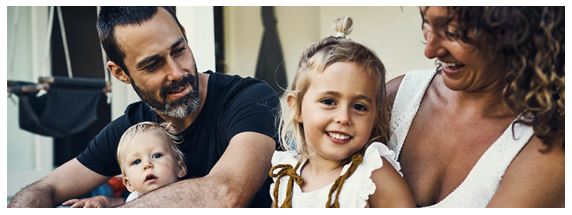

In [4]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
n = np.random.randint(1,data.shape[0])
im = Image.fromarray(data[n][0])
plt.imshow(im)
plt.show()

Set the image dimensions and MobileNet multiplier factor. In this case , we use the baseline Mobilenet with alpha=1

In [5]:
#Image dimensions
img_size = 224
img_h = 224
img_w = 224

#set the multiplier factor for MobileNet
alpha = 1

#number of images
img_count = int(data.shape[0])

Now, we will create the fetaures and the labels from the training data set. This results in 

*X* : Array of 224x224x3 images

masks : Array of labels corresponding to the images 

In [6]:
# Initialize numpy zero arrays
masks = np.zeros([img_count, img_h, img_w])
X = np.zeros([img_count, img_h, img_w, 3])

for idx in range(img_count):

    #Read an image
    img = data[idx][0]
    
    # Resize image to (224,224) using bicubic interpolation
    img = cv2.resize(img, dsize = (img_h, img_w), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    
    # Convert to float32 array
    X[idx] = preprocess_input(np.array(img, dtype = np.float32))
    
    #Extract the x and y coordinates of the mask
    for i in data[idx][1]:
        x1 = int(i['points'][0]['x'] * img_w)
        x2 = int(i['points'][1]['x'] * img_w)
        y1 = int(i['points'][0]['y'] * img_h)
        y2 = int(i['points'][1]['y'] * img_h)
        masks[idx][y1:y2, x1:x2] = 1

Display the shapes of images and masks

In [7]:
print(X.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


There are 409 RGB images of size (224,224) and corresponding masks in the training set

Let us visualize a random image and its correspoding mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


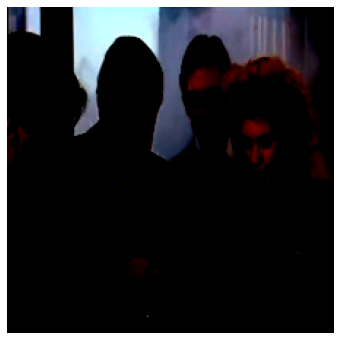

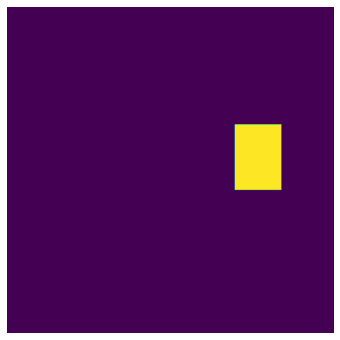

In [8]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
n = np.random.randint(1,img_count)
plt.imshow(X[n])

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(masks[n])

plt.show()

Let us create the model using MobileNet as the base and augmenting it with upsampling layers to create a U-NET architecture

In [9]:
def conv_block(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable=True):
    model = MobileNet(input_shape=(img_h, img_w, 3), include_top=False, alpha=alpha, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_13_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_1_relu").output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block(up1, 256, 'Conv_6_1')
    conv6 = conv_block(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block(up2, 256, 'Conv_7_1')
    conv7 = conv_block(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block(up3, 192, 'Conv_8_1')
    conv8 = conv_block(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block(up4, 96, 'Conv_9_1')
    conv9 = conv_block(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block(up5, 48, 'Conv_10_1')
    conv10 = conv_block(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.3)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((img_size, img_size))(x)
    return Model(inputs = model.input, outputs = x)

Let us define a Dice Coefficient function and a Loss function

In [10]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [11]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

Create the model and view its summary

In [12]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

Compile the model using Adam optimizer. When fitting the model, we will monitor the loss and dice coefficient. To obtain the best model performance, the intent is to minimize the loss and maximize the dice coefficient. 

The Dice coefficient is the ratio of the mask overlap area to the total area. Better the predicted mask, more the overlap area and higher the dice coefficient  

In [13]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Define callbacks to checkpoint the best model, stop early based on loss and tune learning rate

In [14]:
savemodel = ModelCheckpoint("best_model.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
stopearly = EarlyStopping(monitor="val_loss", patience=5)
lranneal = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

Fit the model using the Training images and masks for 20 epochs, validation ratio of 15% and defined callbacks

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, masks, test_size = 0.15, random_state = 42, shuffle = False)
history = model.fit(X_train, y_train, epochs = 20, batch_size = 1, callbacks = [savemodel, lranneal, stopearly], validation_data = (X_val, y_val))

Train on 347 samples, validate on 62 samples
Epoch 1/20
346/347 [============================>.] - ETA: 0s - loss: 1.6527 - dice_coefficient: 0.3696
Epoch 00001: val_loss improved from inf to 1.85266, saving model to best_model.h5
347/347 [==============================] - 55s 57ms/sample - loss: 1.6538 - dice_coefficient: 0.3691 - val_loss: 1.8527 - val_dice_coefficient: 0.3958
Epoch 2/20
347/347 [==============================] - ETA: 0s - loss: 1.1917 - dice_coefficient: 0.4643
Epoch 00002: val_loss improved from 1.85266 to 1.56902, saving model to best_model.h5
347/347 [==============================] - 15s 43ms/sample - loss: 1.1917 - dice_coefficient: 0.4643 - val_loss: 1.5690 - val_dice_coefficient: 0.4519
Epoch 3/20
346/347 [============================>.] - ETA: 0s - loss: 0.9550 - dice_coefficient: 0.5387
Epoch 00003: val_loss improved from 1.56902 to 1.17363, saving model to best_model.h5
347/347 [==============================] - 15s 44ms/sample - loss: 0.9543 - dice_coeffi

Let us summarize model performance

In [16]:
model.evaluate(X_val, y_val, verbose = 1)

[0.8058361488003885, 0.65656567]

Performance on the validation set is noted above. The dice coefficient, which quantifies the performance of image segmentation, averages around 65-70 % 

Let us load the weights of the trained model and predict mask for the test image provided with the assignment pack

In [17]:
# Load weight from the model
WEIGHTS_FILE = "/content/best_model.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_val, verbose = 1)

Load and pre-process the provided sample image for prediction. 

Predict and display the mask for the sample image

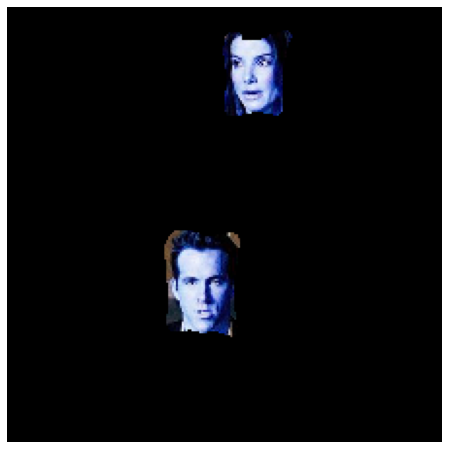

In [18]:
filename = "/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 1Test Data - Prediction Image.jpeg"

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, dsize = (img_h, img_w), interpolation = cv2.INTER_CUBIC)
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

#pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (img_w, img_h))
pred_mask = cv2.resize(1.0*(learned_model.predict(x=np.array([feat_scaled]))[0] > 0.5), (img_w,img_h))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

Display the image mask

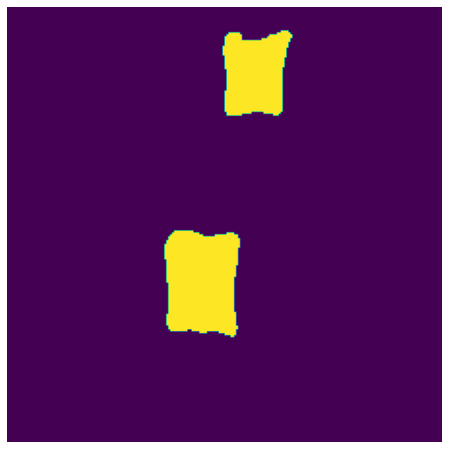

In [19]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

Superimpose the mask on the image 

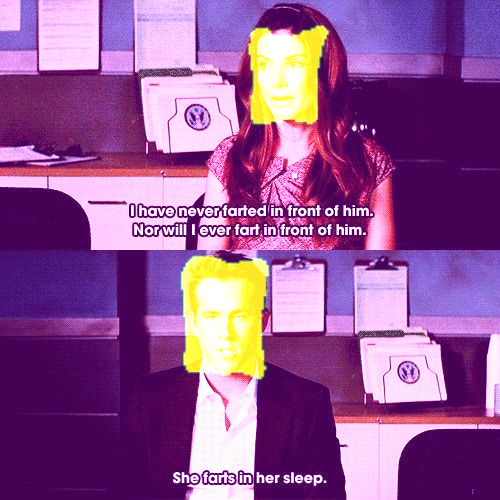

In [20]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

img=cv2.imread(filename,1)
img=cv2.resize(img,(500,500))

mask = cv2.imread('/content/mask.jpg', 1)
mask = cv2.resize(mask, (500,500))

img = cv2.add(img, mask)
cv2_imshow(img)

Conclusion
1. In this section, we used a pretrained MobileNet, added U-NET layers on top of it to create a network for training 
2. The model was complied using binary cross entropy as loss, Adam optimizer and dice coefficient as metric.
3. We trained, fitted and evaluated the above created model and noted the loss and dice coefficient
4. We used callbacks such as Model checkpointing, Early stopping and Learning rate annealing
5. Data was split into training and validation sets (85%/15%). An average dice coeff of 0.9 was observed on the training data and 0.7 on the validation data
6. We loaded the weights of best model and used them to predict the mask on the test image.
7. We displayed the mask predicted by the model and superimposed it on the original test image.

## Part 2 - Face Image Annotation 

The objective of this part of the assignment is to to curate bounding box co-ordinates for each image i.e. annotate the images. Training images are provided for the purpose of annotation. This is done in an automated manner by 
> Taking the training images as inputs
> Passing the images to Haar Cascade, a Machine Learning algorithm that identifies faces in each image
> Generating coordinates of the detected face as outputs

The annotations are written into an Excel spreadsheet that is downloaded

Load the training images and extract them into the working directory

In [21]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 2 - training images.zip"

from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

We define a utility function that writes the given data attributes into an Excel spreadsheet

In [22]:
def writeCsvFile(file_name,data,*args,**kwargs):
    # Opening and writing the csv file
    with open(file_name,"w") as f:
        writer =csv.writer(f)
        writer.writerows(data)

    print ("****** Successfully CSV File Generated *************")

Standardize images to 500 x 500 size and save them to the working directory

In [23]:
def standard_size(image_dir):
    for f in os.listdir(image_dir):
        img_p = os.path.join(image_dir,f)
        im = Image.open(img_p)
        image_data = np.asarray(im)
        file_name=f
        imResize = cv2.resize(image_data, (500, 500))
        try:
            im = Image.fromarray(imResize, 'RGB')
        except ValueError:
            os.remove(img_p)
            print("Bad Image Format, Removing")
            continue
        im.save(image_dir+'/'+f, 'JPEG', quality=90)

Given an image, detect face(s) and return the face coordinates and dimensions

Note: We tried different Haar Cascade XMLs present in https://github.com/opencv/opencv/tree/master/data/haarcascades and retained the XML that provides best detection accuracy

In [24]:
def detect_face(image):
    face_size = 64
    xmin = ymin = xmax = ymax = 0
    frame = np.asarray(image)
    
    # Tried different haarcascade XMLs and retained the one that provided best result
    cascade = "haarcascade_frontalface_default.xml"
    #cascade = "haarcascade_frontalface_alt_tree.xml"
    #cascade = haarcascade_frontalcatface_extended.xml
    #cascade = haarcascade_frontalface_alt2.xml

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade)
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5,minSize=(face_size, face_size), flags=cv2.CASCADE_SCALE_IMAGE)
    face_imgs = np.empty((len(faces), face_size, face_size, 3))
    for i, face in enumerate(faces):
        face_img, cropped = crop_face(frame, face, margin=40, size=face_size)
        (x, y, w, h) = cropped
        if i == 0:
            xmin = x
            ymin = y
            xmax = x+w
            ymax = y+h
    
        (xmin, ymin, xmax, ymax) = face
    return xmin , ymin , xmax-xmin , ymax-ymin, len(faces)

Crop the face

In [25]:
def crop_face( imgarray, section, margin=40, size=64):
        """
        :param imgarray: full image
        :param section: face detected area (x, y, w, h)
        :param margin: add some margin to the face detected area to include a full head
        :param size: the result image resolution with be (size x size)
        :return: resized image in numpy array with shape (size x size x 3)
        """
        img_h, img_w, _ = imgarray.shape
        if section is None:
            section = [0, 0, img_w, img_h]
        (x, y, w, h) = section
        margin = int(min(w,h) * margin / 100)
        x_a = x - margin
        y_a = y - margin
        x_b = x + w + margin
        y_b = y + h + margin
        if x_a < 0:
            x_b = min(x_b - x_a, img_w-1)
            x_a = 0
        if y_a < 0:
            y_b = min(y_b - y_a, img_h-1)
            y_a = 0
        if x_b > img_w:
            x_a = max(x_a - (x_b - img_w), 0)
            x_b = img_w
        if y_b > img_h:
            y_a = max(y_a - (y_b - img_h), 0)
            y_b = img_h
        cropped = imgarray[y_a: y_b, x_a: x_b]
        resized_img = cv2.resize(cropped, (size, size), interpolation=cv2.INTER_AREA)
        resized_img = np.array(resized_img)
        return resized_img, (x_a, y_a, x_b - x_a, y_b - y_a)

Read all images from the image data set and process each image sequentially 

1. Pass the image to the face detection function
2. If the face is successfully detected, get the coordinates and accumulate them into an array
3. Discard images where face detection is not possible i.e. when all coordinates are returned as 0 

In [26]:
def image_process(image_dir,data_list):

    margin = 44 # Default Margin Value of the image
    counter = 0 # To count how many faces detected
    standard_size(image_dir) # Converting all the image to standard size
    for f in os.listdir(image_dir):
        #dir_path=os.path.join(image_dir,dirs)
        #for f in os.listdir(dir_path):
        img_p = os.path.join(image_dir,f)
        label=img_p.split('/')[-2]
        file_name=f
        im = Image.open(img_p) # Opening the image using PILLOW
        img_w,img_h = im.size # getting the width and the height of the image
        size = im.size # for passing the face embeddings parameters
        xmin,ymin,w,h, total_faces=detect_face(im) # Using opencv method
        
        if xmin == ymin == w == h == 0:
            # It will remove the undetected and error image
            os.remove(img_p)
            print("*"+img_p+"*")
            print("********** Error With the Image , So Removing  **********")
            
        else:
            # It will add the detected image
            counter += 1
            print("Face Detected and Processed : {}".format(counter))
            data_list.append([file_name,img_w,img_h,total_faces,xmin,ymin,w,h]) # Appending in a list format
    
    print("**** Successfully image processed *********")

    return data_list

Specify the image data set directory, from where images are read for processing. The processing results contain the following data points
1. Number of faces detected
2. Detected face coordinates, height and width

Annotations generated thus are written to a spreadhseet and downloaded 

In [27]:
data_list = [['filename','image_width','image_height','total_faces','x','y','face_width','face_height']]

# process the images and getting the coordinate values as list
image_dir = "/content/training_images"
csv_name="face_annotations.csv"

coordinate_list = image_process(image_dir,data_list)

# writing into csv file
writeCsvFile(csv_name, coordinate_list)

files.download('/content/face_annotations.csv') 

*/content/training_images/real_00428.jpg*
********** Error With the Image , So Removing  **********
*/content/training_images/real_00374.jpg*
********** Error With the Image , So Removing  **********
Face Detected and Processed : 1
Face Detected and Processed : 2
Face Detected and Processed : 3
Face Detected and Processed : 4
Face Detected and Processed : 5
*/content/training_images/real_00056.jpg*
********** Error With the Image , So Removing  **********
Face Detected and Processed : 6
Face Detected and Processed : 7
Face Detected and Processed : 8
*/content/training_images/real_00775.jpg*
********** Error With the Image , So Removing  **********
Face Detected and Processed : 9
Face Detected and Processed : 10
Face Detected and Processed : 11
Face Detected and Processed : 12
Face Detected and Processed : 13
Face Detected and Processed : 14
*/content/training_images/real_00897.jpg*
********** Error With the Image , So Removing  **********
*/content/training_images/real_00275.jpg*
*****

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Randomly select a few images from the data set and using the generated annotations, draw a box around the detected face for each image 

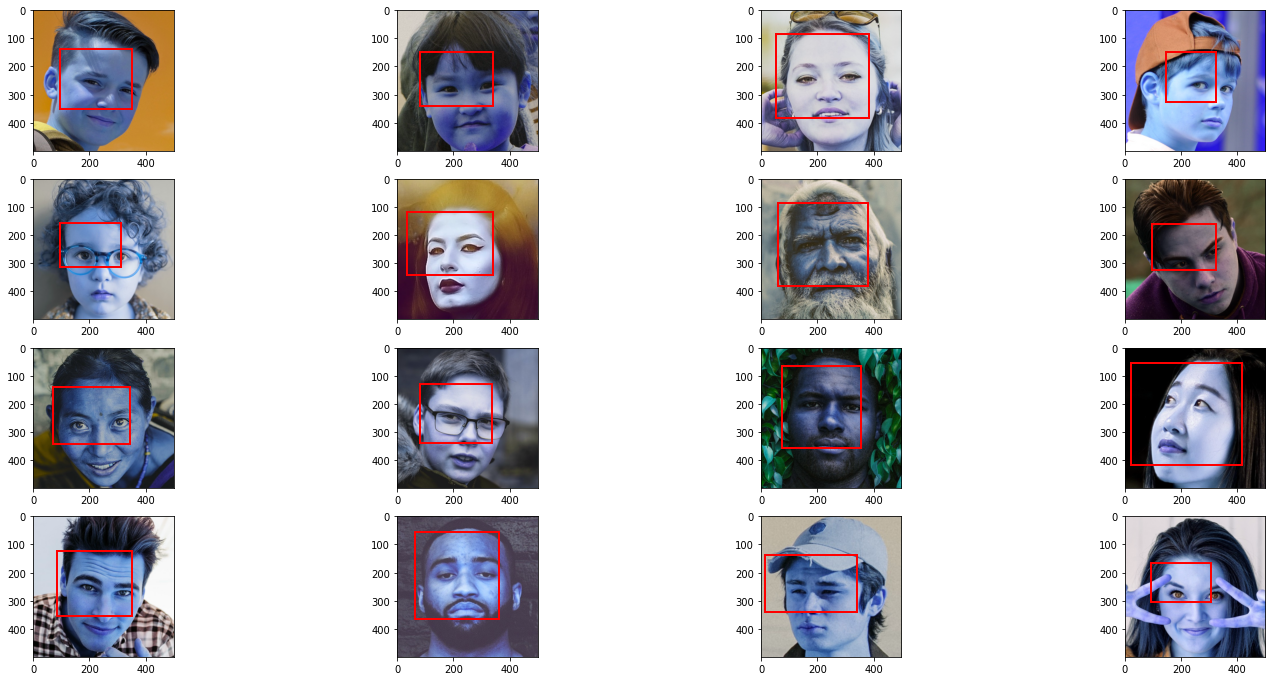

In [28]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

randomlist = random.sample(range(1, 1000), 20)
fig = plt.figure(figsize = (25, 15))

with open('face_annotations.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader, None)
    i=j=0
    for row in reader:
      if i in randomlist:
        path=row[0]
        x_min=int(row[4])
        y_min=int(row[5])
        w=int(row[6])
        h=int(row[7])

        path="/content/training_images/"+path
        img = cv2.imread(path, 1)
        img = cv2.resize(img, dsize = (500, 500))

        ax = fig.add_subplot(5, 4, j+1)
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.imshow(img)
        j+=1
      i+=1

Challenges faced during the task

1. Automating the process of annotating images use machine learning techniques such as Haar Cascade requires very large quantities of image data labelled by humans for it to be effective and efficient. It is difficult to acquire or generate large quantities of data

2. It is important that the images are accurately labelled, so that it is useful to the task at hand. Since any human activity cannot be 100% accurate, the quality of image annotation may not be upto desired levels. Bad annotation quality leads to bad predictions

3. If we need to achieve a high level of quality of annotation over very large image sets, it would require very high levels of human effort and time, which translates to high cost of annotation 

4. The AI team needs to select the right tools and technologies for Image annotations.  There are various tools available in the market specifically for data labeling. Choosing the right tool when balancing annotation quality, cost and features offered can be a tricky challenge for the AI team. 

5. Personal data such as faces, signatures etc. are deemed as PII i.e. personally identifiable information. When labelling them, companies should comply with internal data security and privacy standards. They may also need to comply with international data security standards such as GDPR SOC2, which can be challenging and take time/cost to implement. Cost of non-compliance also tends to be high, which needs to be considered

Conclusion

1. We loaded the images from the training data set
2. We processed each image by passing it through a Face detection function, which outputs the coordinates and dimensions of the face detected
3. We use Haar Cascade to identify faces in the image. 
> * This is based on the concept of ​​ features proposed by Paul Viola and 
Michael Jones in their paper https://ieeexplore.ieee.org/abstract/document/990517
> * It is a machine learning-based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.
4. The Face detection returns the coordinates, dimensions and number of faces in each images, which is then written to a spreadsheet and downloaded as the result.
5. Some images, where faces cannot be detected successfully are discarded in the final result
6. The generated annotations are used to display a bounding box around the faces of randomly selected images from the data set

## Part 3 - Face Recognition

The objective of this part of the assignment is to build a face identification model to recognise human faces, using a Pinterest data set containing 10,770 images for 100 people

In order to recognize similar face, we will use Transfer learning by applying a model pre-trained on Face Recognition. Specifically, we will try to recognize if two given faces belong to the same or different person

We will use the model weights provided over a VGG Network, train the network and use it for prediction

Firstly, we will extract the Pinterest dataset zip file from the mounted Google drive into the working directory



In [29]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 3 - Aligned Face Dataset from Pinterest.zip"

from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

A function to load images from the working directory and map each image with a uniqiue identifier

In [30]:
class ImageMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def build_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            # Consider only .jpg/.jpeg extensions
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(ImageMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = build_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

A function to load image based on its path in the working directory

In [31]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

Using the function written above, let us visualize one arbitrary image from the data set along with its label (person name)

In [32]:
# Take a random image from the dataset
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

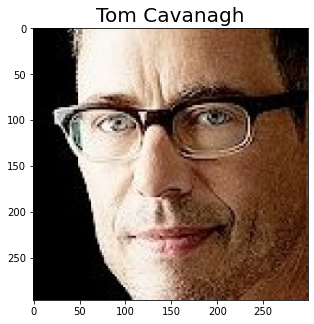

In [33]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

Let us construct a VGG network into which we will load the weights

In [34]:
def facenet_vgg():	
  face_recognizer = Sequential()
  face_recognizer.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
  face_recognizer.add(Conv2D(64, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(64, (3, 3), activation = 'relu'))
  face_recognizer.add(MaxPooling2D((2, 2), strides = (2, 2)))

  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(128, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(128, (3, 3), activation = 'relu'))
  face_recognizer.add(MaxPooling2D((2, 2), strides = (2, 2)))

  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(256, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(256, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(256, (3, 3), activation = 'relu'))
  face_recognizer.add(MaxPooling2D((2, 2), strides = (2, 2)))

  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(MaxPooling2D((2, 2), strides =(2, 2)))

  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(ZeroPadding2D((1, 1)))
  face_recognizer.add(Conv2D(512, (3, 3), activation = 'relu'))
  face_recognizer.add(MaxPooling2D((2, 2), strides=(2, 2)))

  face_recognizer.add(Conv2D(4096, (7, 7), activation = 'relu'))
  face_recognizer.add(Dropout(0.5))
  face_recognizer.add(Conv2D(4096, (1, 1), activation = 'relu'))
  face_recognizer.add(Dropout(0.5))
  face_recognizer.add(Conv2D(2622, (1, 1)))
  face_recognizer.add(Flatten())
  face_recognizer.add(Activation('softmax'))
  
  return face_recognizer

Let us load the network constructed above into a Keras model and load the provided weights into this model 

In [35]:
model = facenet_vgg()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 3 - vgg_face_weights.h5")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     7

Build a Face descriptor model based on the inputs and outputs of the above model

In [36]:
vggface_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

Now, we will generate embeddings for each face image in the dataset

Let us load the first image and get its embedding vector from the pre-trained model

In [37]:
# Get embedding vector for first image using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalize pixel values to a [0..1] scale
img = (img / 255.).astype(np.float32)

#Resize images
img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Generate  embedding vector for the above image using the descriptor model. 
#Display vector shape
embedding_vector = vggface_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


As seen above, there are 2622 elements in the embedding vector

Now, we will generate the embedding vector for all images in the data set. If there is an exception, we generate a all zero vector of size 2622

In [38]:
embvec = []
embvec = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embvec[i] = vggface_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embvec[i] = np.zeros(2622)

We will define Euclidean distance as the distance metric. We write a function to calculate Euclidean distance between two vectors, which will be used to calculate distance between embedding vectors

In [39]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Let us write a function that displays two images along with their distance , given the data set indexes of any two images

In [40]:
def disp_img_dist(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embvec[idx1], embvec[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

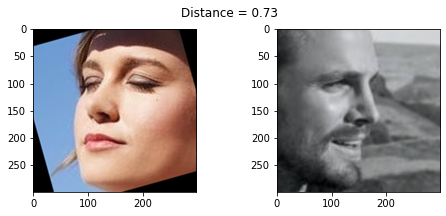

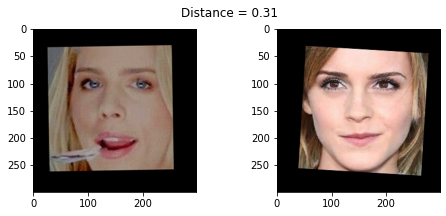

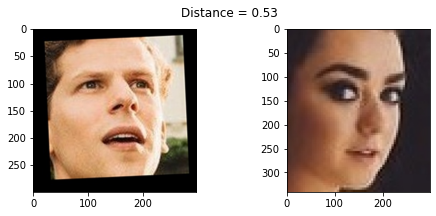

In [41]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

for i in range(3):
  rand1 = np.random.randint(1, len(metadata))
  rand2 = np.random.randint(1, len(metadata))
  disp_img_dist(rand1, rand2)

Let us also visualize similar images and view the distance between them

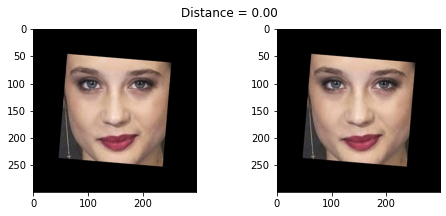

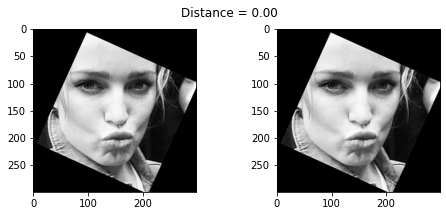

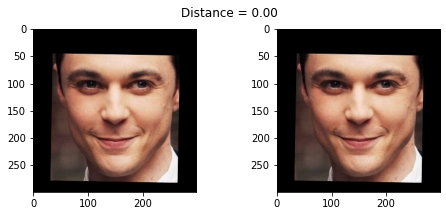

In [42]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

for i in range(3):
  rand1 = np.random.randint(1, len(metadata))
  disp_img_dist(rand1, rand1)

Create train and test sets from the data set 

In [43]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embvec)[train_idx]
X_test = np.array(embvec)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

Encode the train and test labels to 0 or  1 values 

Perform feature scaling

In [44]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

We have 2622 features but not all of them may be strong predictors. Let us analyze the feature importances using cumulative variances. Based on the findings, we will reduce dimensions using Principal Component Analysis

In [45]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.60809707  18.9913552   22.97169984 ...  99.99999983  99.99999999
 100.        ]


Let us determine the number of principa components that can explain 95% cumulative variance

In [46]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


It is observed than 347 features are identified as the most significant for their predictive power, as they can explain above 95% cumulative variance

Let us plot the Prinicpal components and the explained variance ratio

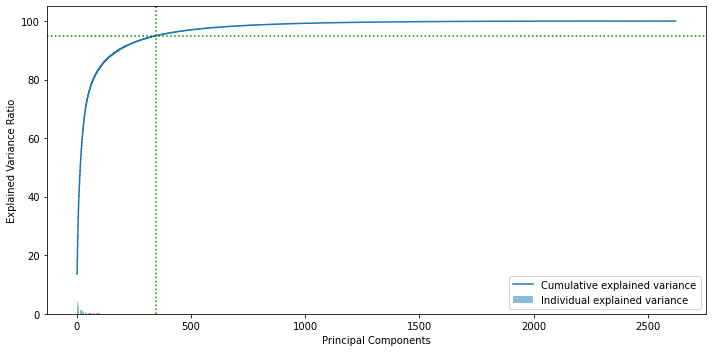

In [47]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.figure(figsize = (10,5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'g', linestyle = 'dotted')
plt.axvline(x = index, color = 'g', linestyle = 'dotted')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Recucing dimensions to 347 as recommended by PCA

In [48]:
# Reducing the dimensions
random_state=42
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

Build and fit a Support Vector Classifier to map each image to person.

Note : The hyperparameters were determined using Randomized GridSearch

 Observe the training accuracy of the model

In [49]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('Accuracy of SVC for the training set: {0:.2f}%'.format(100*svc_pca.score(X_train_pca, y_train)))

Accuracy of SVC for the training set: 99.42%


Make the prediction on the test set and observe the test accuracy of the model

In [50]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(100*accuracy_score(y_test, y_pred).round(2)))

Accuracy Score: 97.0


Let us print the classification report

In [51]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      1.00      1.00        13
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      0.78      0.88         9
        Amber Heard Face       1.00      1.00      1.00         8
               Anna Gunn       1.00      1.00      1.00        15
           Anne Hathaway       1.00      1.00      1.00        13
     Barbara Palvin Face       0.89      0.89      0.89         9
      Bellamy Blake Face       0.93      1.00      0.97        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00         9
              Bill Gates       0.89      0.80      

Let us take a random image from the test set and plot it

Let us determine the person to which it corresponds to

In [52]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vggface_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

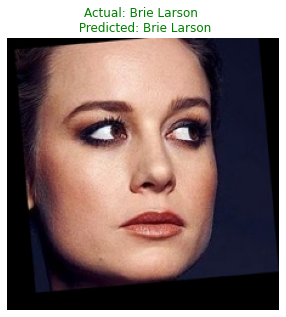

In [53]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

# Plot a random image from the test data
rand = random.randint(1,len(X_test))
sample_img, actual_name, pred_name = sample_img_plot(rand)
fig = plt.figure(figsize = (10,5))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

As it is observed, the right label is predicted for the image. This is the case across multiple prediction tests. Let us now extend the prediction tests for more images

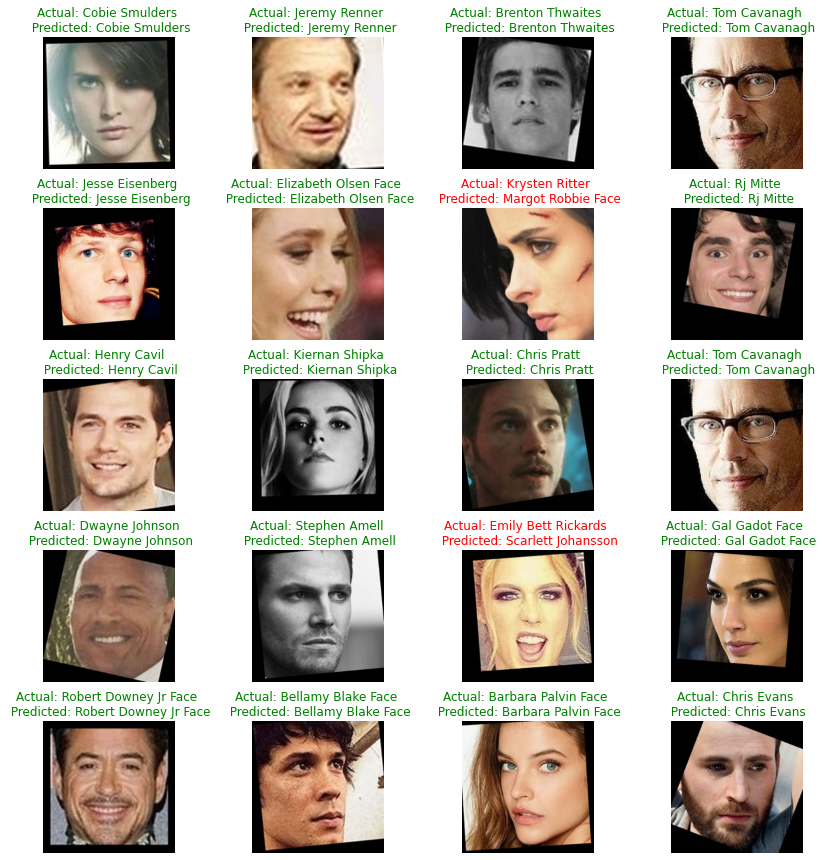

In [54]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

# Random 20 sample images from test data
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

The model predicts the right face to a high degree of accuracy

### Conclusion
1. A VGG network model with pre-trained weights was used to generate embeddings for each images in the dataset.
2. Euclidean distance was chosen as the distance metric. For two arbitrary images, the distance was calculated and visualized.
3. Since there are 2,622 features for each image, we used PCA for dimensionality reduction after feature standardization.
4. 347 principal compoments can cumulatively explain 95% variance and hence we used them.
5. We used Support Vector classifier to predict the labels for test dataset with an accuracy of more than 97%.
6. We compared predicted and actual labels for a given sample image as well as for 20 random images from test dataset. It is observed that the prediction is correct for almost all test cases

Part 3 Appendix : Randomized Gridsearch used to identify the suitable hyperparameters such as C, gamma, kernel and class_weight

In [55]:
# params_grid = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': ['balanced', None]}]

# svc = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'f1_macro', verbose = 50, n_jobs = -1)
# svc.fit(X_train_pca, y_train)

# print('Best estimator found by grid search:')
# print(svc.best_estimator_)

# Best estimator found by grid search:
# SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')

##Part 4 - Traffic Density Estimation

The objective of this section is to automate imputation of dynamic bounding boxes to locate objects on the road. There are 2 sample traffic videos provided. Each video is taken as input, processed to assign bounding boxes and an output video is generated for download

We download and use pixellib library to detect objects in the road using instance segmentation. Moreover, we will use pre-trained Mask R-CNN model to identify vehicles and other objects present in the sample videos.

Instance segmentation segments different instances of the same object with different color maps.

We have already installed pixellib. Now we will download pre-trained Mask R-CNN model and weights from Coco dataset

In [56]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Generate an instance of instance segmentation class offered by pixellib

Load the Mask R-CNN model along with pre-trained weights into the instance. The model was trained on Microsoft Coco dataset, which contains 80 common object categories, on which instance segmentation can be performed. This includes traffic objects such as car, bus, truck, traffic light etc.

In [57]:
segment_video = instance_segmentation()
segment_video.load_model("mask_rcnn_coco.h5")

The approach outlined above automates bounding box assignment in a very simple manner. Using it, the Department of Traffic can understand the road traffic density during busy hours and consequently, efficiently program their traffic lights.

Download the sample videos and extract them into the working directory

In [58]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Assignments/CVAdvanced/Part 4 Video.zip"

from zipfile import ZipFile
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

Set the name, Frames per second (fps) for the output video. To generate segmentation masks with bonding boxes, we set show_bboxes to True. 

Process the video at specified fps, impute bounding boxes, generate and download output video

In [59]:
video_path = "/content/Video/video1.mp4"
segment_video.process_video(video_path, show_bboxes = True, frames_per_second= 15, output_video_name="video1_bb_impute.mp4")
files.download('/content/video1_bb_impute.mp4') 

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Perform the same steps for the second video provided. The same approach can be used for any video 

In [60]:
video_path = "/content/Video/video2.mp4"
segment_video.process_video(video_path, show_bboxes = True, frames_per_second= 15, output_video_name="video2_bb_impute.mp4")
files.download('/content/video2_bb_impute.mp4') 

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Conclusion 

1. We created an automation to impute dynamic bounding boxes to locate objects on the road.

2. We used Instance Segmentation provided by the pixellib library to perform the automation

3. We loaded a pre-trained Mask R-CNN model that is trained to detect many objects, including traffic objects required for this assignment

4. We used the pre-trained model to imputer bounding boxes on the objects present in the video, with a specified frames per second

5. We generated the resultant videos containing the bounding boxes for detected traffic objects. We downloaed the videos to visuaize the traffic density

This concludes all parts of the assignment